In [1]:
#pip install pmdarima
#pip install matplotlib
#pip install nb-black

In [2]:
import pmdarima as pm

In [3]:
# check pmdarima
from pmdarima.arima import auto_arima

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [4]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
import yfinance as yf

<IPython.core.display.Javascript object>

In [6]:
# df = pd.read_csv("C:/Users/User/Desktop/CryptoDatasets/bitcoin_light.csv")
df = yf.download("BTC-USD")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-03-24,42886.652344,44131.855469,42726.164062,43960.933594,43960.933594,31042992291
2022-03-25,43964.546875,44999.492188,43706.285156,44348.730469,44348.730469,30574413034
2022-03-26,44349.859375,44735.996094,44166.273438,44500.828125,44500.828125,16950455995


<IPython.core.display.Javascript object>

In [7]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


<IPython.core.display.Javascript object>

In [8]:
df = df[["Close"]].copy()

<IPython.core.display.Javascript object>

In [9]:
df.describe()

,Close
count,2750.000000
mean,11720.524560
std,16361.021916
min,178.102997
25%,609.364517
50%,6378.314453
75%,10766.162842
max,67566.828125


<IPython.core.display.Javascript object>

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

#### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [10]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.8156446001505556
p-value: 0.8144833353101343


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

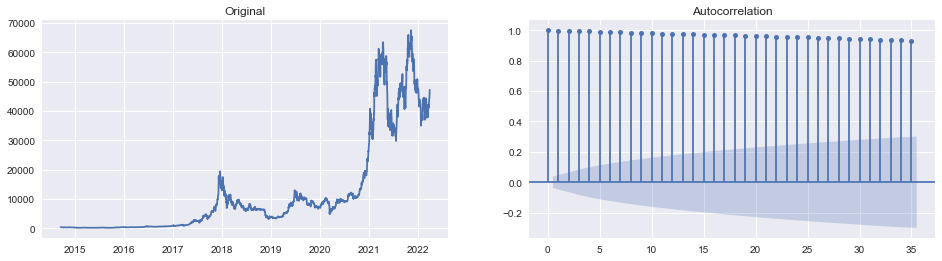

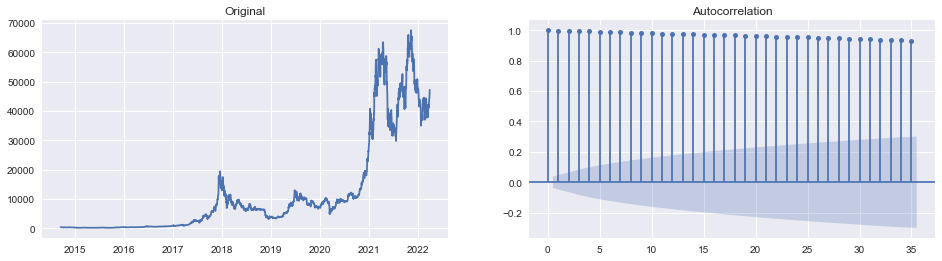

<IPython.core.display.Javascript object>

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

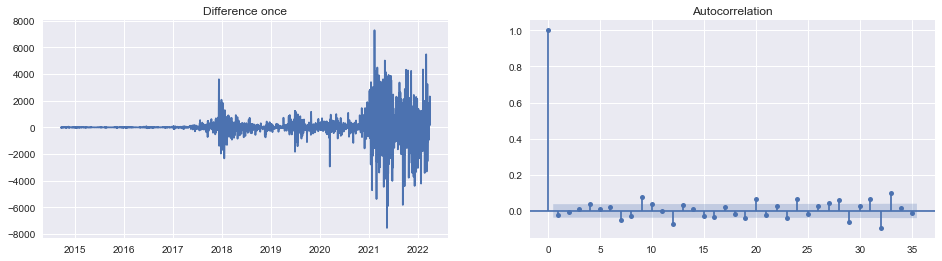

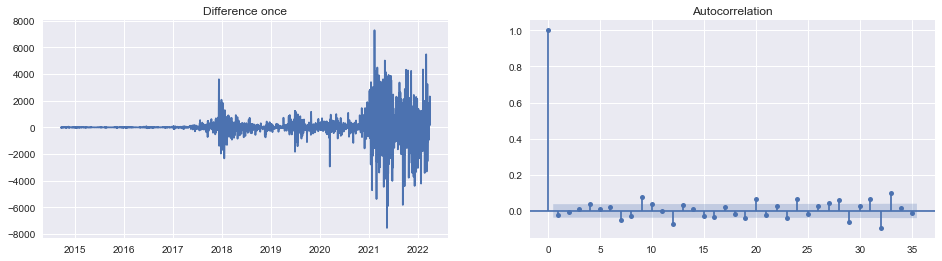

<IPython.core.display.Javascript object>

In [13]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

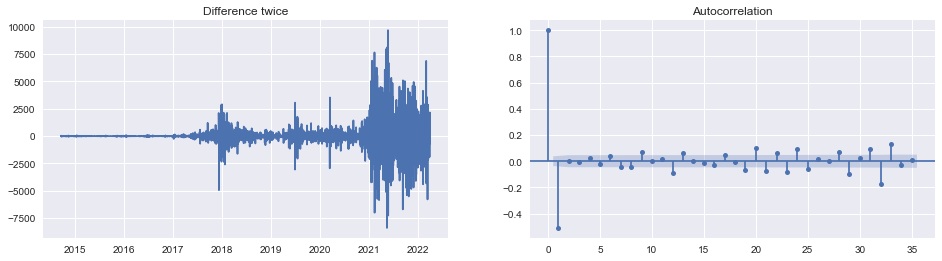

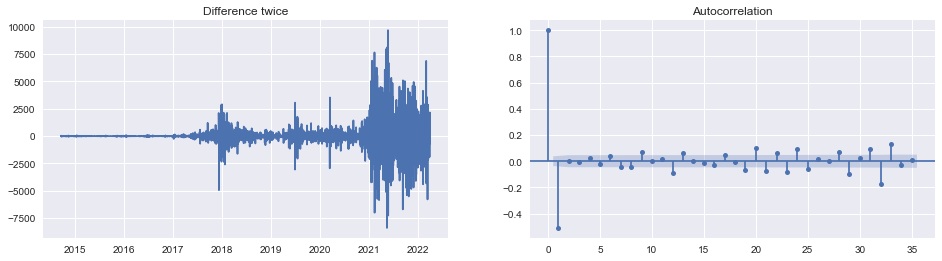

<IPython.core.display.Javascript object>

In [14]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

We can use the pmdarima package to get the number of differencing.

In [15]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [16]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

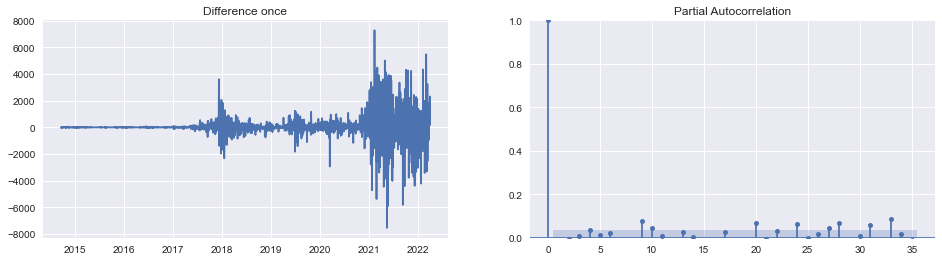

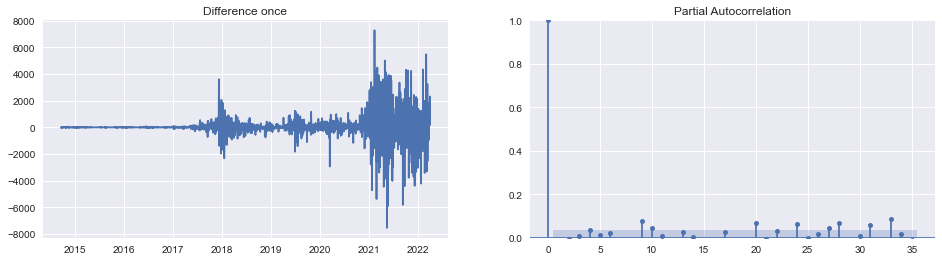

<IPython.core.display.Javascript object>

In [18]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag ? is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

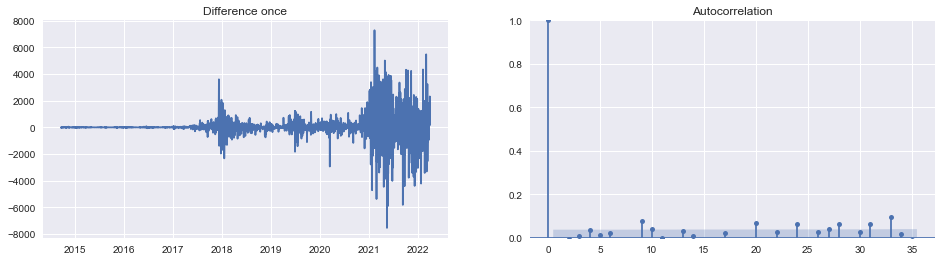

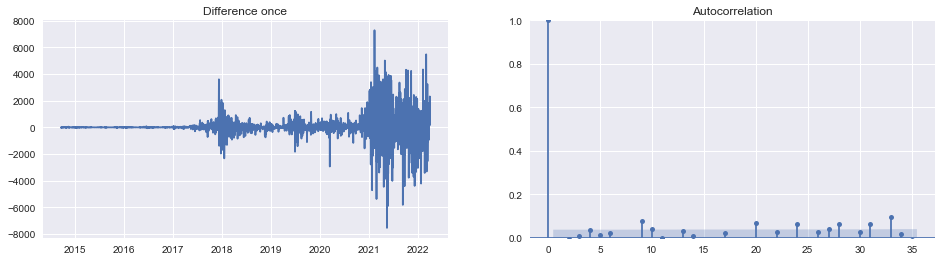

<IPython.core.display.Javascript object>

In [19]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

#### Fitting the ARIMA model

In [32]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.Close, order=(0, 1, 0))
result = model.fit(disp=0)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will 

<IPython.core.display.Javascript object>

In [33]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2749
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -22241.338
Method:                           css   S.D. of innovations            789.787
Date:                Mon, 28 Mar 2022   AIC                          44486.676
Time:                        14:30:44   BIC                          44498.514
Sample:                    09-18-2014   HQIC                         44490.953
                         - 03-28-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0267     15.063      1.130      0.258     -12.497      46.550


<IPython.core.display.Javascript object>

(array([2.45010515e-07, 9.80042061e-07, 4.16517876e-06, 1.17605047e-05,
        1.03884458e-04, 5.28242671e-04, 1.76407571e-05, 5.14522082e-06,
        1.22505258e-06, 2.45010515e-07]),
 array([-7571.06580872, -6086.35955872, -4601.65330872, -3116.94705872,
        -1632.24080872,  -147.53455872,  1337.17169128,  2821.87794128,
         4306.58419128,  5791.29044128,  7275.99669128]),
 <BarContainer object of 10 artists>)

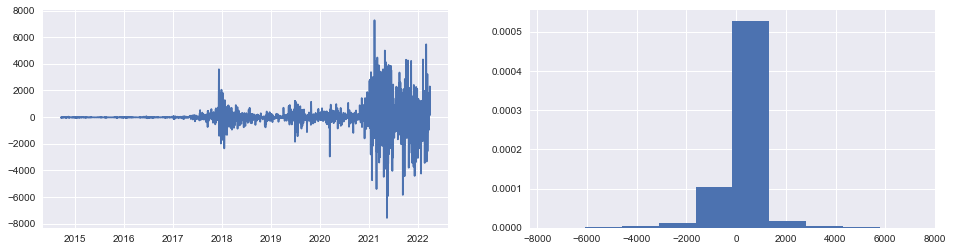

<IPython.core.display.Javascript object>

In [34]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


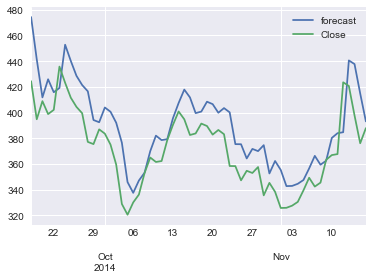

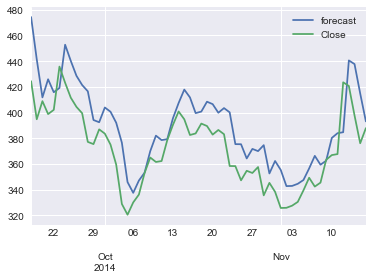

<IPython.core.display.Javascript object>

In [35]:
# Actual vs Fitted
result.plot_predict(
    start=1, end=60, dynamic=False,
)

### Train test split 

In [36]:
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

<IPython.core.display.Javascript object>

In [37]:
print(len(train))
print(len(test))

2200
550


<IPython.core.display.Javascript object>

In [38]:
step = 30

model = ARIMA(train, order=(2, 1, 1))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will 

<IPython.core.display.Javascript object>

In [39]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

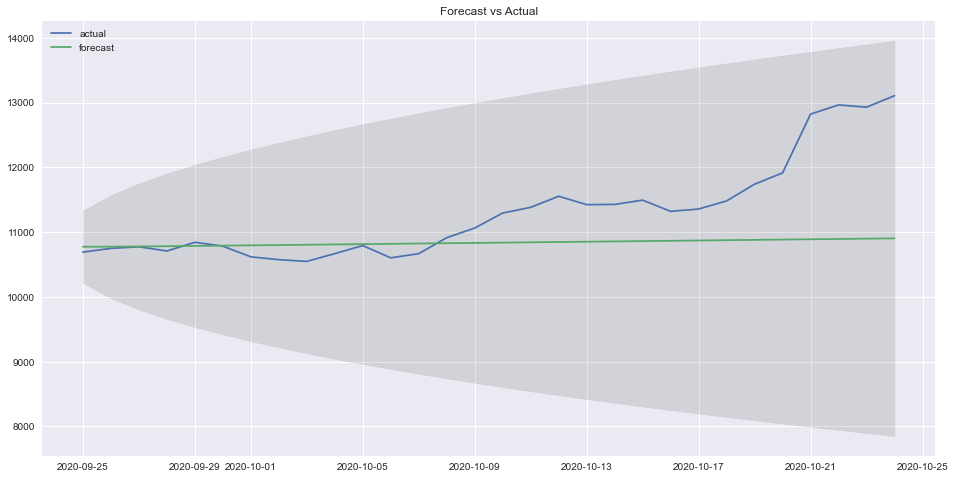

<IPython.core.display.Javascript object>

In [40]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

### Auto ARIMA

The pmdarima package provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [41]:
from pmdarima.arima import auto_arima

<IPython.core.display.Javascript object>

In [42]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44489.241, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44486.676, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44487.254, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44487.247, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44485.954, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.277 seconds


<IPython.core.display.Javascript object>

In [ ]:
df.close